In [1]:
import pathlib
import random
import string
import re
import numpy as np

import jax.numpy as jnp
import optax

from flax import nnx

import tiktoken
import grain.python as grain
import tqdm

In [2]:
import requests
import zipfile
import tempfile

url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

with tempfile.TemporaryDirectory() as temp_dir:
    temp_path = pathlib.Path(temp_dir)
    zip_file_path = temp_path / "spa-eng.zip"

    response = requests.get(url)
    zip_file_path.write_bytes(response.content)

    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(temp_path)

    text_file = temp_path / "spa-eng" / "spa.txt"

    with open(text_file) as f:
        lines = f.read().split("\n")[:-1]
    text_pairs = []
    for line in lines:
        eng, spa = line.split("\t")
        spa = "[start] " + spa + " [end]"
        text_pairs.append((eng, spa))

In [3]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [4]:
tokenizer = tiktoken.get_encoding("cl100k_base")

In [5]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = tokenizer.n_vocab
sequence_length = 20

In [6]:
vocab_size

100277

In [7]:
def custom_standardization(input_string):
    lowercase = input_string.lower()
    return re.sub(f"[{re.escape(strip_chars)}]", "", lowercase)

In [8]:
def tokenize_and_pad(text, tokenizer, max_length):
    tokens = tokenizer.encode(text)[:max_length]
    padded = tokens + [0] * (max_length - len(tokens)) if len(tokens) < max_length else tokens ##assumes list-like - (https://github.com/openai/tiktoken/blob/main/tiktoken/core.py#L81 current tiktoken out)
    return padded

In [9]:
def format_dataset(eng, spa, tokenizer, sequence_length):
    eng = custom_standardization(eng)
    spa = custom_standardization(spa)
    eng = tokenize_and_pad(eng, tokenizer, sequence_length)
    spa = tokenize_and_pad(spa, tokenizer, sequence_length)
    return {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:-1],
            "target_output": spa[1:],
            }

In [10]:
train_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in train_pairs]
val_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in val_pairs]
test_data = [format_dataset(eng, spa, tokenizer, sequence_length) for eng, spa in test_pairs]

In [11]:
## data selection example
print(train_data[135])

{'encoder_inputs': [576, 19665, 3388, 374, 539, 1825, 311, 2536, 23832, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'decoder_inputs': [29563, 60, 10566, 16622, 78, 409, 19665, 2092, 9157, 1560, 3429, 9686, 91568, 510, 408, 60, 0, 0, 0], 'target_output': [60, 10566, 16622, 78, 409, 19665, 2092, 9157, 1560, 3429, 9686, 91568, 510, 408, 60, 0, 0, 0, 0]}


In [12]:
from transformer import BlockConfig, TransformerConfig
from transformer import EncDecTransformer

In [13]:
batch_size = 64 #set here for the loader and model train later on
num_epochs = 10

class CustomPreprocessing(grain.MapTransform):
    def __init__(self):
        pass

    def map(self, data):
        return {
            "encoder_inputs": np.array(data["encoder_inputs"]),
            "decoder_inputs": np.array(data["decoder_inputs"]),
            "target_output": np.array(data["target_output"]),
        }

train_sampler = grain.IndexSampler(
    len(train_data),
    shuffle=True,
    seed=12,                        # Seed for reproducibility
    shard_options=grain.NoSharding(), # No sharding since it's a single-device setup
    num_epochs=1,                    # Iterate over the dataset for one epoch
)

val_sampler = grain.IndexSampler(
    len(val_data),
    shuffle=False,
    seed=12,
    shard_options=grain.NoSharding(),
    num_epochs=1,
)

train_loader = grain.DataLoader(
    data_source=train_data,
    sampler=train_sampler,                 # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        CustomPreprocessing(),
        grain.Batch(batch_size=batch_size, drop_remainder=True),
    ]
)

val_loader = grain.DataLoader(
    data_source=val_data,
    sampler=val_sampler,
    worker_count=4,
    worker_buffer_size=2,
    operations=[
        CustomPreprocessing(),
        grain.Batch(batch_size=batch_size),
    ]
)

In [14]:
def compute_loss(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels)
    return jnp.mean(loss)

In [15]:
import jax
@nnx.jit
def train_step(model, optimizer, batch):
    def loss_fn(model, train_encoder_input, train_decoder_input, train_target_input):
        logits = model(train_encoder_input, train_decoder_input)
        loss = compute_loss(logits, train_target_input)
        return loss

    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, jnp.array(batch["encoder_inputs"]), jnp.array(batch["decoder_inputs"]), jnp.array(batch["target_output"]))
    optimizer.update(grads)
    return loss

@nnx.jit
def eval_step(model, batch, eval_metrics):
    logits = model(jnp.array(batch["encoder_inputs"]), jnp.array(batch["decoder_inputs"]))
    loss = compute_loss(logits, jnp.array(batch["target_output"]))
    labels = jnp.array(batch["target_output"])
    # jax.debug.print("logits: {logits}", logits=logits)
    # jax.debug.print("labels: {labels}", labels=labels)
    # jax.debug.print("loss: {loss}", loss=loss)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [16]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [17]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(train_data) // batch_size

def train_one_epoch(epoch, model, optimizer):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch, model):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for val_batch in val_loader:
        eval_step(model, val_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [18]:
# ## Hyperparameters
# rng = nnx.Rngs(0)
# embed_dim = 128
# latent_dim = 512
# num_heads = 4
# dropout_rate = 0.5
# vocab_size = tokenizer.n_vocab
# sequence_length = 20


block_cfg = BlockConfig(
    d_model=128,
    d_ff=512,
    num_heads=4,
    head_dim=32,
    attn_dropout_rate=0.2,
    mlp_dropout_rate=0.2,
    attn_weights_dtype=jnp.float32,
    mlp_weights_dtype=jnp.float32,
)

transformer_cfg = TransformerConfig(
    num_layers=2,
    vocab_size=tokenizer.n_vocab,
    max_seq_len=sequence_length,
    embedding_dtype=jnp.float32,
    block_cfg=block_cfg)

learning_rate = 1.5e-3
model = EncDecTransformer(transformer_cfg, rngs=nnx.Rngs(0))

warmup_steps = 1000
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-6,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=10000
)
optimizer = nnx.Optimizer(model, optax.adamw(lr_scheduler))


In [19]:
# Count number of parameters in the model
import numpy as np
import jax

def count_params(model):
    params = nnx.state(model, nnx.Param)
    total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(params))
    print(total_params)

count_params(model)

13758080


In [20]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, optimizer)
    evaluate_model(epoch, model)
    # break

[train] epoch: 0/10, [1300/1301], loss=1.45 [00:50<00:00]


[test] epoch: 1/10
- total loss: 1.3593
- Accuracy: 0.7633


[train] epoch: 1/10, [1300/1301], loss=0.951 [00:24<00:00]


[test] epoch: 2/10
- total loss: 0.9521
- Accuracy: 0.8232


[train] epoch: 2/10, [1300/1301], loss=0.774 [00:23<00:00]


[test] epoch: 3/10
- total loss: 0.8278
- Accuracy: 0.8434


[train] epoch: 3/10, [1300/1301], loss=0.61 [00:23<00:00] 


[test] epoch: 4/10
- total loss: 0.7669
- Accuracy: 0.8554


[train] epoch: 4/10, [1300/1301], loss=0.521 [00:23<00:00]


[test] epoch: 5/10
- total loss: 0.7307
- Accuracy: 0.8638


[train] epoch: 5/10, [1300/1301], loss=0.417 [00:23<00:00]


[test] epoch: 6/10
- total loss: 0.7079
- Accuracy: 0.8696


[train] epoch: 6/10, [1300/1301], loss=0.388 [00:23<00:00]


[test] epoch: 7/10
- total loss: 0.6973
- Accuracy: 0.8719


[train] epoch: 7/10, [1300/1301], loss=0.395 [00:23<00:00]


[test] epoch: 8/10
- total loss: 0.6964
- Accuracy: 0.8720


[train] epoch: 8/10, [1300/1301], loss=0.382 [00:24<00:00]


[test] epoch: 9/10
- total loss: 0.6964
- Accuracy: 0.8720


[train] epoch: 9/10, [1300/1301], loss=0.368 [00:24<00:00]


[test] epoch: 10/10
- total loss: 0.6964
- Accuracy: 0.8720


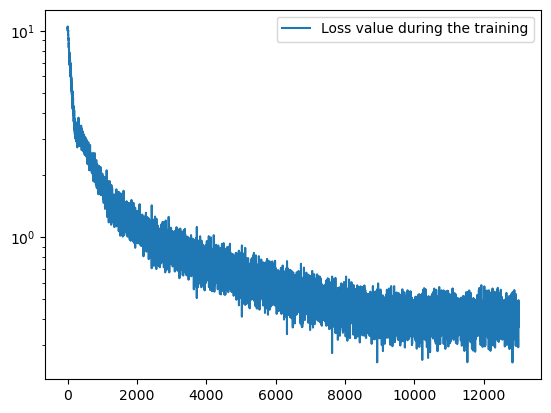

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.yscale('log')
plt.legend()

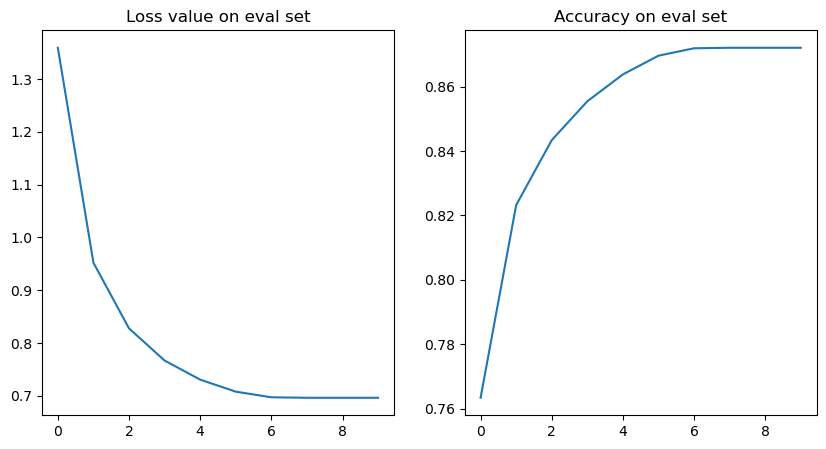

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Loss value on eval set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on eval set")
axs[1].plot(eval_metrics_history["test_accuracy"])

In [29]:
def decode_sequence(input_sentence):

    input_sentence = custom_standardization(input_sentence)
    tokenized_input_sentence = tokenize_and_pad(input_sentence, tokenizer, sequence_length)

    decoded_sentence = "[start"
    for i in range(sequence_length):
        tokenized_target_sentence = tokenize_and_pad(decoded_sentence, tokenizer, sequence_length)[:-1]
        predictions = model(jnp.array([tokenized_input_sentence]), jnp.array([tokenized_target_sentence]))

        sampled_token_index = np.argmax(predictions[0,i, :]).item(0)
        sampled_token = tokenizer.decode([sampled_token_index])
        decoded_sentence += "" + sampled_token

        if decoded_sentence[-5:] == "[end]":
            break
    return decoded_sentence

In [30]:
test_eng_texts = [pair[0] for pair in test_pairs]

In [31]:
test_result_pairs = []
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    test_result_pairs.append(f"[Input]: {input_sentence} [Translation]: {translated}")

In [32]:
for i in test_result_pairs:
    print(i)

[Input]: I need to buy food, but I don't have enough money. [Translation]: [start] necesito comprar comida pero no tengo dinero suficiente [end]
[Input]: He's a gardener. [Translation]: [start] él es un jardinero [end]
[Input]: We got ready. [Translation]: [start] estábamos listos [end]
[Input]: He's a bigot. [Translation]: [start] él es una autilla [end]
[Input]: I don't want you to think I'm crazy. [Translation]: [start] no quiero que piensas que estoy loco [end]
[Input]: Don't call us, we'll call you. [Translation]: [start] no nos llamáis bien [end]
[Input]: Did you leave a tip? [Translation]: [start] dejaste una punta de punta [end]
[Input]: Tom is still in bed. [Translation]: [start] tom todavía está en la cama [end]
[Input]: I haven't eaten for two days. [Translation]: [start] no he comido por dos días [end]
[Input]: She has a great appetite for adventure. [Translation]: [start] ella tiene un gran apetito para aventuras [end]
